# A/B Testing- Final project assignment

## TASK DESCRIPTION:
The analytic task was ordered by an international online store.
A new payment funnel has been introduced to the company, and they wish to analyze changes related to its effectiveness.

The experiment has been running for 2 weeks between the 7/12/20 and 1/1/21 (but from the 21/12/20 new users stopped being taken in).
The samples are 15% of the new users from the EU region.
The Control group saw the old payment funnel, and the test group- the new one.
Expected number of test participants: 6000

The expected results are that within 14 days of signing up users will show at least a 10% increase in each stage of the funnel product_page → product_cart → purchase. 
More specifically we expect to see:
- Better conversion into product page views (the product_page event), 
- More instances of adding items to the shopping cart (product_cart),
- More purchases (purchase). 

Data was saved onto 4 datasets:
- 1. ab_project_marketing_events_us.csv — includes the calendar of marketing events for 2020
- 2. final_ab_new_users_upd_us.csv — includes all users who signed up in the online store from December 7 to 21, 2020
- 3. final_ab_events_upd_us.csv — includes all events of the new users within the period from Dec 7, 2020 through Jan 1, 2021
- 4. final_ab_participants_upd_us.csv — includes table containing participants by test group (A or B)

## Loading libraries and data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import datetime as dt
import sidetable
import seaborn as sns
import plotly.graph_objects as go
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sidetable

Note: you may need to restart the kernel to use updated packages.


In [4]:
try:
    mark_eve = pd.read_csv(r"C:\Users\USER\OneDrive\מסמכים\DATA ANALYST\Practicum100\Final Sprint\A-B testing section\ab_project_marketing_events_us.csv")
    all_users = pd.read_csv(r"C:\Users\USER\OneDrive\מסמכים\DATA ANALYST\Practicum100\Final Sprint\A-B testing section\final_ab_new_users_upd_us.csv")
    events = pd.read_csv(r"C:\Users\USER\OneDrive\מסמכים\DATA ANALYST\Practicum100\Final Sprint\A-B testing section\final_ab_events_upd_us.csv")
    test_grps= pd.read_csv(r"C:\Users\USER\OneDrive\מסמכים\DATA ANALYST\Practicum100\Final Sprint\A-B testing section\final_ab_participants_upd_us.csv")
    
except:
    mark_eve = pd.read_csv("\Datasets\ab_project_marketing_events_us.csv")
    all_users = pd.read_csv("\Datasets\final_ab_new_users_upd_us.csv")
    events = pd.read_csv("\Datasets\final_ab_events_upd_us.csv")
    test_grps= pd.read_csv("\Datasets\final_ab_participants_upd_us.csv")

## Preprocessing data:

In [5]:
print("MARKETING EVENTS:")
mark_eve.head()
mark_eve.info()
print("------------------------------------")
print()
print("ALL USERS:")
all_users.head()
all_users.info()
all_users['region'].value_counts()
all_users['device'].value_counts()

print("------------------------------------")
print()
print("EVENTS:")
events.head()
events.info()
events.event_name.value_counts()

print("------------------------------------")
print()
print("TEST GROUP USERS:")
test_grps.head()
test_grps.info()
test_grps.group.value_counts()
test_grps.ab_test.value_counts()

MARKETING EVENTS:


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
------------------------------------

ALL USERS:


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


EU           43396
N.America     9051
CIS           3130
APAC          3126
Name: region, dtype: int64

Android    26159
PC         14845
iPhone     11902
Mac         5797
Name: device, dtype: int64

------------------------------------

EVENTS:


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: event_name, dtype: int64

------------------------------------

TEST GROUP USERS:


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


A    8214
B    6311
Name: group, dtype: int64

interface_eu_test          10850
recommender_system_test     3675
Name: ab_test, dtype: int64

#### Issues that need attention:
- *Marketing events*: In the relevant testing dates there is a Christmas & New Year Promo in the EU region. Although this marketing event will happen equally in both the A and B groups, it might still contaminate our research and limit our ability to generalize the results to beyond this context. Aside from that, the table doesn't seem to have other relevant info, and so I won't bother exploring it deeper than that.
- *Users*: No missing values, but quite a lot of non-European regions to be dropped from the dataset. After doing so, I should check the device distribution again. 
- *Events*: The "details" variable has a very large amount of missing values. This is logical since it matches the number of users that acctually reached the purchase event (14.23% of users). The distribution of events hints to the funnel order, but it should be noted that the data still needs to be cleansed from non-EU users, and devided to the control and test groups.
- *Test groups*: no missing values. However-The division to test groups doesn't seem to match the test names allocated to them. I should look into it and verify that there aren't users exposed to both groups.
- data types of dates and time need to be converted.

***To sum up***:
I need to:
- 1 Select only relevant region.
- 2 Select only relevant date range
- From test group table- select only users that meet these two conditions and appear in only one test-group (A or B), and that group and description match. 
- (Since A is so much larger than B, maybe an A/A test is manageable too..?)

Looks like we will be left with much less users than originally expected...


## Cleaning up data:

### 1. Converting data types:

In [6]:
# Changing to datetime:
mark_eve['start_dt'] =  pd.to_datetime(mark_eve['start_dt'], format='%Y-%m-%d') 
mark_eve['finish_dt'] =  pd.to_datetime(mark_eve['finish_dt'], format='%Y-%m-%d') 
all_users['first_date']= pd.to_datetime(all_users['first_date'], format='%Y-%m-%d') 
events['event_dt']= pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S') 

 

In [7]:
# Looking into descriptive stat:
mark_eve.describe(include="all").T
all_users.describe(include="all").T
events.describe(include="all").T
test_grps.describe(include="all").T

C:\Users\USER\AppData\Local\Temp/ipykernel_11148/252196223.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  mark_eve.describe(include="all").T


,count,unique,top,freq,first,last
name,14,14,Christmas&New Year Promo,1,NaT,NaT
regions,14,6,APAC,4,NaT,NaT
start_dt,14,14,2020-12-25 00:00:00,1,2020-01-25,2020-12-30
finish_dt,14,14,2021-01-03 00:00:00,1,2020-02-07,2021-01-07


C:\Users\USER\AppData\Local\Temp/ipykernel_11148/252196223.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  all_users.describe(include="all").T


,count,unique,top,freq,first,last
user_id,58703,58703,D72A72121175D8BE,1,NaT,NaT
first_date,58703,17,2020-12-21 00:00:00,6077,2020-12-07,2020-12-23
region,58703,4,EU,43396,NaT,NaT
device,58703,4,Android,26159,NaT,NaT


C:\Users\USER\AppData\Local\Temp/ipykernel_11148/252196223.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  events.describe(include="all").T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
user_id,423761,58703,A3917F81482141F2,36,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_dt,423761,257138,2020-12-14 18:54:55,10,2020-12-07 00:00:33,2020-12-30 23:36:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_name,423761,4,login,182465,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
details,60314.0,NaN,NaN,NaN,NaT,NaT,23.881219,72.228884,4.99,4.99,4.99,9.99,499.99


,count,unique,top,freq
user_id,14525,13638,307C06C0E6F09B93,2
group,14525,2,A,8214
ab_test,14525,2,interface_eu_test,10850


### 2. Checking for missing or duplicate values:
(Missing- see "Issues that need attention" above.

In [8]:
# duplicates were not found:
print("all_users duplicates:", all_users.duplicated().sum())
print("events duplicates:", events.duplicated().sum())
print("test_grps duplicates:", test_grps.duplicated().sum())

all_users duplicates: 0
events duplicates: 0
test_grps duplicates: 0


### 3. Select relevant region:

In [9]:
# drop non-EU users from all_users dataset:
all_users= all_users[all_users['region'] == "EU"]
all_users.region.unique()
all_users= all_users[['user_id', 'first_date', 'device']]

array(['EU'], dtype=object)

In [10]:
# match the users on events dataset to the all_users dataset:
user_ids= all_users['user_id'].unique()
events= events[events['user_id'].isin(user_ids)]


In [11]:
#checking if it worked:
all_users['user_id'].nunique()
events['user_id'].nunique()

43396

43396

### 4. Select relevant date range :
(First dates being between 7/12/20 to 21/12/21 and last dates being all the way till 1/1/21)

In [12]:
# all_users:
all_users= all_users.loc[all_users['first_date'].between('2020-12-07','2020-12-20', inclusive=True)]
all_users.sort_values(by= 'first_date')

C:\Users\USER\AppData\Local\Temp/ipykernel_11148/87193444.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  all_users= all_users.loc[all_users['first_date'].between('2020-12-07','2020-12-20', inclusive=True)]


,user_id,first_date,device
0,D72A72121175D8BE,2020-12-07,PC
3525,C6435CD7B8A161E7,2020-12-07,Android
3526,93384A9D3598C56B,2020-12-07,iPhone
3528,F41040A15B0AC503,2020-12-07,PC
3529,B44FA1599E5095D7,2020-12-07,Android
...,...,...,...
55967,94441E066A630662,2020-12-20,PC
55968,A54406507F625E60,2020-12-20,iPhone
55969,9B8BD9BA28F84109,2020-12-20,iPhone
55874,F23C07704A9516BD,2020-12-20,Android


In [13]:
# events: 
events= events.loc[events['event_dt'].between('2020-12-07 00:00:00','2021-01-01 00:00:00', inclusive=True)]
events.sort_values(by= 'event_dt')


C:\Users\USER\AppData\Local\Temp/ipykernel_11148/1199293439.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  events= events.loc[events['event_dt'].between('2020-12-07 00:00:00','2021-01-01 00:00:00', inclusive=True)]


,user_id,event_dt,event_name,details
756,EB2D1E4A76B38E24,2020-12-07 00:00:33,purchase,9.99
243582,EB2D1E4A76B38E24,2020-12-07 00:00:33,login,NaN
121935,EB2D1E4A76B38E24,2020-12-07 00:00:34,product_page,NaN
243463,821D82C2BB74CBB2,2020-12-07 00:00:35,login,NaN
121862,821D82C2BB74CBB2,2020-12-07 00:00:35,product_page,NaN
...,...,...,...,...
423734,F9452D9C3B463498,2020-12-30 20:41:37,login,NaN
60303,F9452D9C3B463498,2020-12-30 20:41:37,purchase,4.99
120420,F9452D9C3B463498,2020-12-30 20:41:40,product_cart,NaN
60306,CE065914C815ADF6,2020-12-30 23:02:44,purchase,9.99


In [14]:
# comparing the number of users:
all_users['user_id'].nunique()
events['user_id'].nunique()

35018

43396

In [15]:
# limiting data to 14 days per user, as requested:
# 1. adding a simple date column, without hours:
events['date']= events['event_dt'].dt.date

#2. merging tables:
user_events= events.merge(all_users, on='user_id', how= 'left')
user_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314777 entries, 0 to 314776
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     314777 non-null  object        
 1   event_dt    314777 non-null  datetime64[ns]
 2   event_name  314777 non-null  object        
 3   details     46687 non-null   float64       
 4   date        314777 non-null  object        
 5   first_date  265216 non-null  datetime64[ns]
 6   device      265216 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 19.2+ MB


In [16]:
# changing data type of new column
user_events['date']= pd.to_datetime(user_events['date'], format='%Y-%m-%d')

In [17]:
# 3. calculating time range in days:
user_events['time_range']= user_events['date'] - user_events['first_date']
user_events['time_range']= user_events['time_range'].dt.days.astype('int', errors='ignore')
user_events.head(3)

,user_id,event_dt,event_name,details,date,first_date,device,time_range
0,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,2020-12-07,iPhone,0.0
1,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,2020-12-07,iPhone,0.0
2,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,2020-12-07,Android,0.0


In [18]:
# calculating the number of rows in which experiment lasted more than 14 days:
more14= user_events[user_events['time_range'] > 14]
more14.sort_values(by='time_range', ascending= False).head()
print("There are {} rows with a too long time range.".format(len(more14)))

,user_id,event_dt,event_name,details,date,first_date,device,time_range
314776,7AEC61159B672CC5,2020-12-30 11:36:13,login,NaN,2020-12-30,2020-12-07,iPhone,23.0
91233,114953E781C03385,2020-12-30 19:45:10,product_cart,NaN,2020-12-30,2020-12-07,iPhone,23.0
46680,CE065914C815ADF6,2020-12-30 23:02:44,purchase,9.99,2020-12-30,2020-12-07,iPhone,23.0
46681,09B67269EB574925,2020-12-30 03:19:10,purchase,4.99,2020-12-30,2020-12-07,PC,23.0
46682,BA38083E4065AF28,2020-12-30 01:43:39,purchase,99.99,2020-12-30,2020-12-07,Mac,23.0


There are 10063 rows with a too long time range.


In [19]:
# dropping these rows:
user_events= user_events[user_events['time_range'] <= 14]


In [20]:
# comparing the number of users:
all_users['user_id'].nunique()
events['user_id'].nunique()
user_events['user_id'].nunique()

35018

43396

35013

### 5.  Preparing the test_grps table:

In [21]:
# dropping non-EU user:
test_grps= test_grps[test_grps['user_id'].isin(user_ids)]

In [22]:
# choosing the relevant test name for this project (recommender_system_test):
# 1. looking into the proportion of the tests

test_grps.ab_test.value_counts(normalize=True)

interface_eu_test          0.7571
recommender_system_test    0.2429
Name: ab_test, dtype: float64

In [23]:
# 2. checking if users in groups A and B are "contaminated" (participated in both tests). If they were, we cannot know for sure 
# which test affected the results. Therefore, it would be best to not include them in our final sample.
# GROUP A:
grpA= test_grps[test_grps['group'] == 'A']
tes1= grpA[grpA['ab_test'] == "recommender_system_test"]['user_id']
tes2=grpA[grpA['ab_test'] == "interface_eu_test"]['user_id']


In [24]:
# searching for intersect of users participating in both tests:
com = np.intersect1d(tes1, tes2)
howmany_com = len(com)
howmany_com

340

In [25]:
# GROUP B:
grpB= test_grps[test_grps['group'] == 'B']
test1= grpB[grpB['ab_test'] == "recommender_system_test"]['user_id']
test2=grpB[grpB['ab_test'] == "interface_eu_test"]['user_id']

In [26]:
# searching for intersect of user participating in both tests:
common = np.intersect1d(test1, test2)
howmany_common = len(common)
howmany_common

106

As can be seen, for both groups A and B there is a large number of users that participated in both tests.
We don't know the influence of the "interface" test, or if there may be an interaction between the two tests and a joint effect.
It seems that the in order to stay on the safe side, especially with this messy sample, we should only stay with users that did not participate in the "interface" test at all.

In [27]:
# filtering out these users
test_grps = test_grps[~test_grps['user_id'].isin(com)]
test_grps = test_grps[~test_grps['user_id'].isin(common)]

In [28]:
# 3. filtering out the irrelevant test as well:
test_grps= test_grps[test_grps['ab_test'] == "recommender_system_test"]
test_grps.ab_test.value_counts()
test_grps= test_grps[['user_id','group']]

recommender_system_test    3035
Name: ab_test, dtype: int64

In [29]:
# checking if the group assignment is exhaustive and exclusive:
# 1. creating two lists
usersA = test_grps[test_grps['group'] == 'A']['user_id']
usersB= test_grps[test_grps['group'] == 'B']['user_id']

In [30]:
# 2. finding common elements to the two groups: (none)
common_elements = np.intersect1d(usersA, usersB)
common_elements

array([], dtype=object)

### 6. Re-adjusting the user_ids in the other tables:

In [31]:
# subsetting a list of final user_ids:
final_ids= test_grps['user_id'].unique()
final_ids

array(['D1ABA3E2887B6A73', 'A7A3664BD6242119', '4FF2998A348C484F', ...,
       'E26F13A65CEAC6EA', '95401934D6D6D4FC', '80712ED4EA1B52A5'],
      dtype=object)

In [32]:
len(final_ids)

3035

In [33]:
# using this list as a filter on the 2 other tables:
all_users= all_users[all_users['user_id'].isin(final_ids)]
events= events[events['user_id'].isin(final_ids)]

In [34]:
# re-checking:
all_users['user_id'].nunique()
events['user_id'].nunique()
test_grps['user_id'].nunique()

2619

3035

3035

In [35]:
# calculating 15% of the original amount of EU new users: (more than double what we ended up with)
fifteen = (15*43396)/100
fifteen

6509.4

#### A summary of the preprocessing stage:
Preprocessing included a few stages:
1. Converting date and time variables to the right data type.
2. Checking for missing values and duplicates (no duplicated, and no missing values).
3. Filtering out data that did not match requirements: wrong regions, wrong date-range, wrong test.
- filtering out the wrong test required a few stages, in which users from both groups (A and B) that participated in both tests were identified and filtered out as well. Also, filtering the wrong dates included removal of users that joined the site more than 14 days ago.
4. After doing so, we did not find any users that were exposed to both test groups.
5. We ended up with a much smaller sample than expected: 3035 users (2619 of which registered in the first two weeks). 

## Exploratory data analysis:
Study conversion at different stages of the funnel.
Is the number of events per user distributed equally among the samples?
Are there users who are present in both samples?
How is the number of events distributed among days?
Are there any peculiarities in the data that you have to take into account before starting the A/B test?

In [36]:
# (just a reminder for me...)
all_users.head(2)
events.head(2)
test_grps.head(2)

,user_id,first_date,device
0,D72A72121175D8BE,2020-12-07,PC
19,DD4352CDCF8C3D57,2020-12-07,Android


,user_id,event_dt,event_name,details,date
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07


,user_id,group
0,D1ABA3E2887B6A73,A
1,A7A3664BD6242119,A


### Study conversion at different stages of the funnel

In [37]:
# merging events with groups:
events_grp = events.merge(test_grps, on='user_id', how='left')

events_grp.head()

,user_id,event_dt,event_name,details,date,group
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,A
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,A
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,B
3,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,B
4,2F46396B6766CFDB,2020-12-07 13:29:30,purchase,4.99,2020-12-07,A


In [38]:
# subsetting to two groups:
grp_A= events_grp[events_grp['group'] == "A"]
grp_B= events_grp[events_grp['group'] == "B"]


In [39]:
# GROUP A:

funnelA= grp_A.groupby('event_name')['user_id'].nunique().reset_index()
funnelA= funnelA.rename(columns={"user_id": "users_count"})

# reordering by funnel order:
funnelA= funnelA.reindex([0, 2, 1, 3])
print("Funnel A:")
funnelA


Funnel A:


,event_name,users_count
0,login,2264
2,product_page,1474
1,product_cart,685
3,purchase,712


In [40]:
base= funnelA.iloc[0]['users_count']
funnelA['CR, %']= (funnelA['users_count']/ base) * 100
funnelA

,event_name,users_count,"CR, %"
0,login,2264,100.000000
2,product_page,1474,65.106007
1,product_cart,685,30.256184
3,purchase,712,31.448763


In [41]:
# GROUP B:
funnelB= grp_B.groupby('event_name')['user_id'].nunique().reset_index()
funnelB= funnelB.rename(columns={"user_id": "users_count"})

# reordering by funnel order:
funnelB= funnelB.reindex([0, 2, 1, 3])
print("Funnel B:")
funnelB

Funnel B:


,event_name,users_count
0,login,770
2,product_page,429
1,product_cart,214
3,purchase,219


In [42]:
baseb= funnelB.iloc[0]['users_count']
funnelB['CR, %']= (funnelB['users_count']/ baseb) * 100
funnelB

,event_name,users_count,"CR, %"
0,login,770,100.000000
2,product_page,429,55.714286
1,product_cart,214,27.792208
3,purchase,219,28.441558


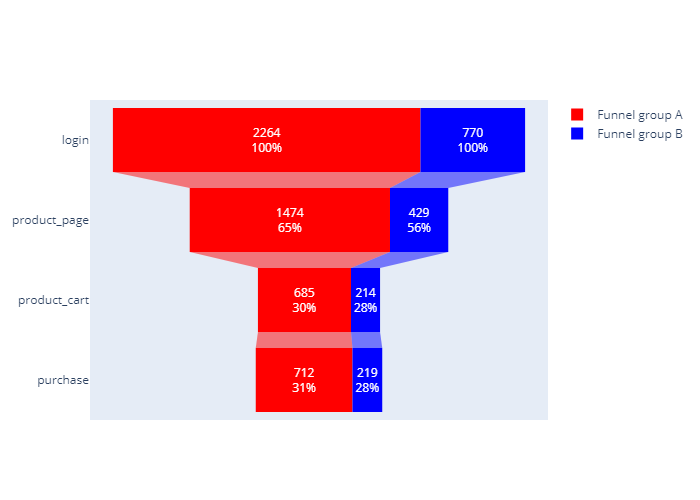

In [43]:
# Visualizing the two funnels:
fig = go.Figure()
fig.add_trace(go.Funnel(y = funnelA['event_name'], x = funnelA['users_count'],
                        orientation = "h",
                        name= 'Funnel group A',
                        marker= {"color": "red"},
                        textposition = "inside",
                        textinfo = "value+percent initial"))
              
fig.add_trace(go.Funnel(y = funnelB['event_name'], x = funnelB['users_count'],
                        orientation = "h",
                        name= 'Funnel group B',
                        textposition = "inside",
                        marker= {"color": "blue"},
                       textinfo = "value+percent initial"))

#fig.update_layout(
         #   autosize

fig.show("png");

#### Funnel visualization:
There are a few noticeable things in these funnels:
- 1. The number of users do not follow the order of the stages in the funnel, and so we have buyers that did not pass through the product cart stage. This might mean that there was an option on the product page for direct purchase, without adding the item to the cart.
- 2. Conversion rates compared to the initial login stage: The largest difference between the funnels is in passing from login stage to product page. Group A managed to retain 65% of its users, whereas group B- only 56%.
- 3. Conversion rates compared to the previous stage: looking at this indicator, we see a different picture- passing from the product page stage to the cart stage, group B retained 50% of its users, and group A- only 46.5%

### Is the number of events per user distributed equally among the samples?

In [44]:
# seperate tables by group:
print("GROUP A")
eve_num_A= grp_A.groupby('user_id')['event_name'].count().reset_index().sort_values(by='event_name')
eve_num_A.columns=['user_id', 'events']
eve_num_A
print()
print("GROUP B")
eve_num_B= grp_B.groupby('user_id')['event_name'].count().reset_index().sort_values(by='event_name')
eve_num_B.columns=['user_id', 'events']
eve_num_B


GROUP A


,user_id,events
591,4400B2091A6E2CCD,1
517,3B3AE26404B64EF2,1
1239,8F5B3D96E7D43A02,1
1408,A0FCDFB113ABF06F,1
126,10387B8D694D539C,1
...,...,...
2209,F9D53F0BA957F728,20
1999,E20504D0CAD45AF3,20
967,6E3DF9C69A6B607E,21
252,1BFEE479308EFF44,24



GROUP B


,user_id,events
312,6A07E9483E1D2638,1
86,1E7B931452B2F965,1
102,25B6EE0F91D32DB9,1
127,2CEC84A86958E639,1
659,DAEE6D470B64E11B,1
...,...,...
766,FE76759FE6BF8C68,20
369,7E8720DB6A21CF66,20
407,89545C7F903DBA34,21
41,115EBC1CA027854A,24


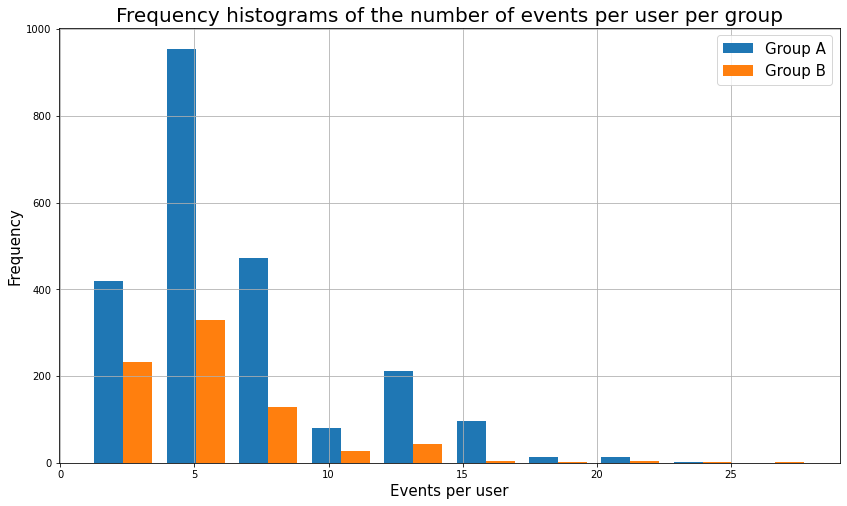

In [45]:
# plotting histograms of the number of events per user per group:
plt.figure(figsize=(14,8))
plt.hist([eve_num_A['events'], eve_num_B['events']], label=['Group A', 'Group B'])
plt.legend(loc=1, prop={'size': 15})
plt.grid()
plt.xlabel("Events per user", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Frequency histograms of the number of events per user per group", fontsize=20)
plt.show();

In [46]:
# We can also calculate the average number of events per user, and this way overpass the problem of sample sizes:
print("The average number of events per user in group A is:", eve_num_A['events'].mean())
print("The average number of events per user in group B is:", eve_num_B['events'].mean())

The average number of events per user in group A is: 6.774734982332156
The average number of events per user in group B is: 5.592736705577172


In [47]:
# To see the distribution in evenly sized groups:
len(eve_num_A)
len(eve_num_B)
eve_num_a = eve_num_A.sample(771)


2264

771

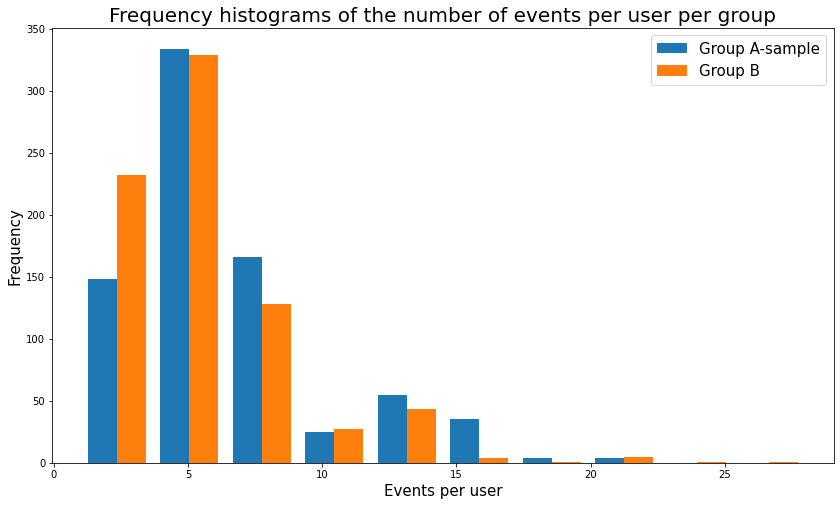

In [48]:
plt.figure(figsize=(14,8))
plt.hist([eve_num_a['events'], eve_num_B['events']], label=['Group A-sample', 'Group B'])
plt.legend(loc=1, prop={'size': 15})
plt.xlabel("Events per user", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Frequency histograms of the number of events per user per group", fontsize=20)
plt.show();

#### Frequency histograms:
- It can be seen that the number of events per user ranges between 1 and 24 (group A) and 1 to 28 (group B), with the most frequent situation being around 5 events per user, and the least frequent being in the high numbers.
- The distributions of the two groups seemed somewhat similar when having different sample sizes, but with evenly sized groups it can be seen that the slopes between the bars are different. 
- Compared with the control group, the test group (B) has a higher frequency of users with 1-5 events, the same amount of users performing 5 events, and a higher frequency of 10-event users. Between 12 and 20 events per user the lead goes to group A, however, over 20 events per user we'll find a higher frequency of users in the B group.

### How is the number of events distributed among days?

In [49]:
# resizing group A to match group B:
len(grp_A)
len(grp_B)
grp_a= grp_A.sample(4312)
len(grp_a)

15338

4312

4312

In [50]:
# creating a distribution table- events per day per group:
# GROUP a:
eve_dt_a= grp_a.groupby('date')['event_name'].count().reset_index().sort_values(by='date')
eve_dt_a= eve_dt_a.rename(columns={'event_name': 'events_p_day'})
print("GROUP A- sample:")
eve_dt_a

GROUP A- sample:


,date,events_p_day
0,2020-12-07,78
1,2020-12-08,74
2,2020-12-09,75
3,2020-12-10,70
4,2020-12-11,91
5,2020-12-12,76
6,2020-12-13,73
7,2020-12-14,259
8,2020-12-15,249
9,2020-12-16,234


In [51]:
# group A (full group):
eve_dt_A= grp_A.groupby('date')['event_name'].count().reset_index().sort_values(by='date')
eve_dt_A= eve_dt_A.rename(columns={'event_name': 'events_p_day'})

In [52]:

# GROUP B:
eve_dt_B= grp_B.groupby('date')['event_name'].count().reset_index().sort_values(by='date')
eve_dt_B= eve_dt_B.rename(columns={'event_name': 'events_p_day'})
print("GROUP B:")
eve_dt_B

GROUP B:


,date,events_p_day
0,2020-12-07,315
1,2020-12-08,207
2,2020-12-09,289
3,2020-12-10,218
4,2020-12-11,137
5,2020-12-12,169
6,2020-12-13,122
7,2020-12-14,227
8,2020-12-15,187
9,2020-12-16,322


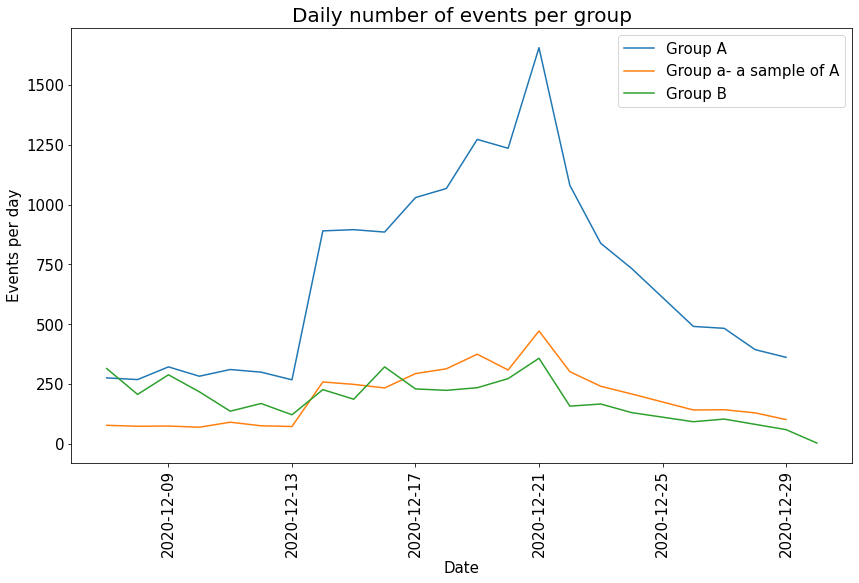

In [63]:
# A line plot of the number of events per day, per group:
# (I took both a and A to make sure that the distributions are similar.. )
plt.figure(figsize=(14,8))
plt.plot(eve_dt_A['date'], eve_dt_A['events_p_day'], label='Group A')
plt.plot(eve_dt_a['date'], eve_dt_a['events_p_day'], label='Group a- a sample of A')
plt.plot(eve_dt_B['date'], eve_dt_B['events_p_day'], label='Group B')
plt.legend(loc=1, prop={'size': 15})
plt.xlabel("Date", fontsize=15)
plt.ylabel("Events per day", fontsize=15)
plt.title("Daily number of events per group", fontsize=20)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15);

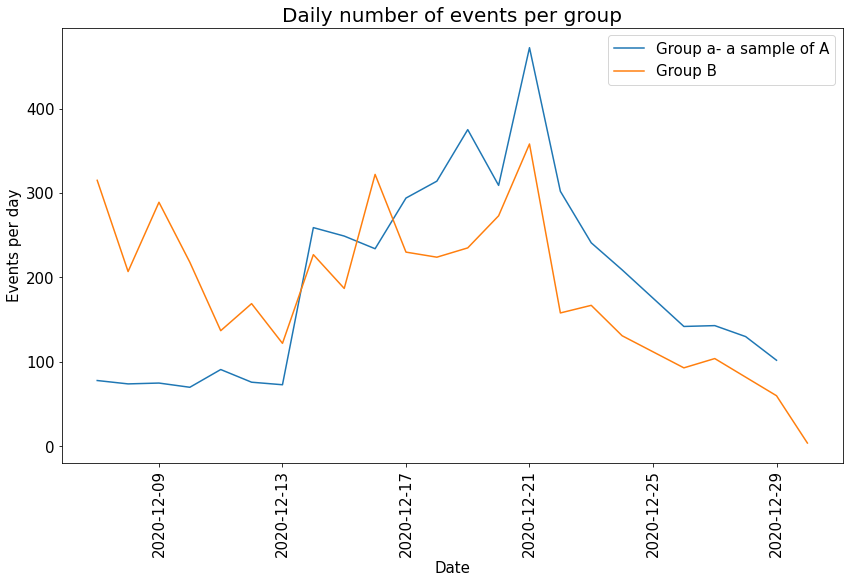

In [64]:
# to better see the two groups, i'll remove A:
plt.figure(figsize=(14,8))
plt.plot(eve_dt_a['date'], eve_dt_a['events_p_day'], label='Group a- a sample of A')
plt.plot(eve_dt_B['date'], eve_dt_B['events_p_day'], label='Group B')
plt.legend(loc=1, prop={'size': 15})
plt.xlabel("Date", fontsize=15)
plt.ylabel("Events per day", fontsize=15)
plt.title("Daily number of events per group", fontsize=20)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15);

#### Daily number of events per group:
As can be seen, the daily number of events is distributed very differently from the 7th of Dec to the 21st. From this day on, though, the two groups follow similar trajectories all the way till the 31st.
- Group A: until the 13/12 the daily number of events is very low and stable (around 100). On the 13th there is a steep and gradual rise in the the number of daily events, that continues all the way to the 21st. This peak day is shared by group B as well. From this day on, both groups lose users: the number of daily events drops in group A back to 100, and reaches almost 0 in group B.

- Group B: group B starts the experiment with a total of 300 eents a day. Yet, the group's trajectory is less stable than group A: The number of daily events fluctuates considerably around 200, until the 21st, in which the number drops gradualy to 0.  

I assume that Christmass and New year have something to do with it. The marketing in EU, though, started only on the 25th and seemingly might have not affected the results.

In [55]:
# just checking.. (doesn't seem like a sig difference)
events_grp.groupby('group')['details'].mean()

group
A    22.55323
B    21.15426
Name: details, dtype: float64

## A/B Testing:

Evaluate the A/B test results:
What can you say about the A/B test results?
Use a z-test to check the statistical difference between the proportions.


***H0 (Null):*** Group A and group B have the same conversion rates- There is no statistically significant difference between them.

***H1 (Alternative):*** The conversion rate of group B will be at least 10% higher than the one of group A.

**Test selection**: A two sample Z-test for Proportions.

**Rational:** this test is used to check if two samples are drawn from the same population. It is utilized when the population proportion is unknown, as in out case, and it uses the standard normal distribution to calculate the test statistic.

In order to check the hypothesis, 3 comparisons will be run:
- 1. The proportion of product page from login page. 
- 2. The proportion of product cart from product page. 
- 3. The proportion of purchase page from product cart.

**Setting alpha:** There are 3 comparisons, in addition to having a one sided hypothesis, so we need to decrease the alpha by half and devide it in 3. alpha= 0.05/6= 0.0083

In [56]:
# a reminder:
grp_A.head(2)
grp_B.head(2)

,user_id,event_dt,event_name,details,date,group
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,A
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,A


,user_id,event_dt,event_name,details,date,group
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,B
3,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,B


In [57]:
#preparing data:
stage0A= grp_A.query('event_name == "login"')
stage1A= grp_A.query('event_name == "product_page"') 
stage2A= grp_A.query('event_name == "product_cart"')
stage3A= grp_A.query('event_name == "purchase"')

stage0B= grp_B.query('event_name == "login"')
stage1B= grp_B.query('event_name == "product_page"') 
stage2B= grp_B.query('event_name == "product_cart"')
stage3B= grp_B.query('event_name == "purchase"')

In [58]:
# preparing a function to check hypotheses:
def ztest_prop(first_A, second_A, first_B, second_B):
    #Preparing the relevant variables
    vis_A= first_A['user_id'].nunique()
    buy_A= second_A['user_id'].nunique()
    vis_B= first_B['user_id'].nunique()
    buy_B= second_B['user_id'].nunique()
    
    print("Group A:")
    print("  VisitorsA", vis_A)
    print("  BuyersA", buy_A)
    print()
    print("Group B:")
    print("  VisitorsB", vis_B)
    print("  BuyersB", buy_B)

    # running the test:
    alpha = .05 / 6
    stat1, pval1 = proportions_ztest([buy_A,buy_B], [vis_A,vis_B])
    print('P-Value:{0:0.3f}'.format(pval1))
    if (pval1 < alpha):
        print("Null hypothesis rejected: there is a significant difference between conversion rates")
    else:
        print("Failed to reject the null hypothesis: there is no significant difference between the conversion rates") 
    print ("Group A conversion rate:{0:0.3f}".format(buy_A/vis_A))
    print ("Group B conversion rate:{0:0.3f}".format(buy_B/vis_B))

### 1. Conversion login:product page- proportion comparison

In [59]:
ztest_prop(stage0A, stage1A, stage0B, stage1B)

Group A:
  VisitorsA 2264
  BuyersA 1474

Group B:
  VisitorsB 770
  BuyersB 429
P-Value:0.000
Null hypothesis rejected: there is a significant difference between conversion rates
Group A conversion rate:0.651
Group B conversion rate:0.557


- Results indicate that in the first stage of the funnel the conversion rate in our test group is significantly **LOWER** than the one seen in the control group. Out first hypothesis, therefore, has been rejected: The new system did not yield better conversion rates in the first stage of the funnel.

### 2. Conversion product page:product cart- proportion comparison

In [60]:
ztest_prop(stage1A, stage2A, stage1B, stage2B)

Group A:
  VisitorsA 1474
  BuyersA 685

Group B:
  VisitorsB 429
  BuyersB 214
P-Value:0.213
Failed to reject the null hypothesis: there is no significant difference between the conversion rates
Group A conversion rate:0.465
Group B conversion rate:0.499


### 3. Conversion product cart:purchase- proportion comparison

In [61]:
ztest_prop(stage2A, stage3A, stage2B, stage3B)

Group A:
  VisitorsA 685
  BuyersA 712

Group B:
  VisitorsB 214
  BuyersB 219
P-Value:nan
Failed to reject the null hypothesis: there is no significant difference between the conversion rates
Group A conversion rate:1.039
Group B conversion rate:1.023


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\stats\proportion.py:860: RuntimeWarning:

invalid value encountered in sqrt



### 4. Overall conversion from login to purchase:


In [62]:
ztest_prop(stage0A, stage3A, stage0B, stage3B)

Group A:
  VisitorsA 2264
  BuyersA 712

Group B:
  VisitorsB 770
  BuyersB 219
P-Value:0.118
Failed to reject the null hypothesis: there is no significant difference between the conversion rates
Group A conversion rate:0.314
Group B conversion rate:0.284


- In all other stages of the funnel, including the comparison of the first to the last stage, differences in the conversion rates were NOT found to be statistically significant. Hence, all our hypotheses were rejected- the new system does not yield better conversion results.

## Conclusions:


This A/B test dealt with the effectiveness, in terms of conversion rates, of a new system introduced into an international online store.
The Control group was exposed the old payment funnel, and the test group- to the new one.
The experiment ran for 2 weeks between the 7/12/20 and 1/1/21 (but from the 21/12/20 new users stopped being taken in).
The participants were 7% of the new users from the EU region (not 15% as originally expected).
The number of test participants was around 3000 (not 6000, as originally expected)

The expected results were that within 14 days of signing up users will show at least a 10% increase in each stage of the funnel product_page → product_cart → purchase.

Due to some errors in the collection of data, we had to exclude from the final sample quite a lot of data.
**The preprocessing stage included a few stages:**
1. Converting date and time variables to the right data type.
2. Checking for missing values and duplicates (no duplicated, and no missing values).
3. Filtering out data that did not match requirements: wrong regions, wrong date-range, wrong test.
- filtering out the wrong test required a few stages, in which users from both groups (A and B) that participated in both tests were identified and filtered out as well. Also, filtering the wrong dates included removal of users that joined the site more than 14 days ago.
4. After doing so, we did not find any users that were exposed to both test groups.
5. We ended up with a much smaller sample than expected: 3035 users (2619 of which registered in the first two weeks). 

In the **exploratory data anlysis** we explored the two groups' funnels and the conversion rates between their stages, as well as measures such as the number of events per user and the dynamic of the number of events by time.

- **The number of events per user** ranged between 1 and 24 (group A) and 1 to 28 (group B), with an average of 5.59 events per user in group B and 6.67- in group A.
Compared with the control group, the test group (B) had a higher frequency of users with 1-5 events, the same amount of users performing 5 events, and a higher frequency of 10-event users. Between 12 and 20 events per user the lead went to group A, but, over 20 events per user we found a higher frequency of users in the B group (though an overall very low frequency).

- **Daily number of events per group:**
The daily number of events was distributed very differently from the 7th of Dec to the 21st. From this day on, though, the two groups follow similar trajectories all the way till the 31st.

Group A: until the 13/12 the daily number of events was very low and stable (around 100). On the 13th there was a steep and gradual rise in the the number of daily events, that continues all the way to the 21st. From this day, both groups lost users.

Group B: group B started the experiment with a total of 300 events a day. Yet, the group's trajectory was less stable than group A: The number of daily events fluctuates considerably, until the 21st, in which the number drops gradualy to 0.

I assume that Christmass and New year have something to do with it. The marketing in EU, though, started only on the 25th and seemingly might have not affected the results.

**Conversion wise we found that:**
- 1. Some of the buyers skipped the cart stage of the funnel - there was probably an option on the product page for direct purchase.
- 2. Conversion rates compared to the initial login stage: The largest difference between the funnels was in passing from login stage to product page. Group A managed to retain 65% of its users, whereas group B- only 56%.
- 3. Conversion rates compared to the previous stage: looking at this indicator, we see a different picture- passing from the product page stage to the cart stage, group B retained 50% of its users, and group A- only 46.5%

**The A/B testing** run was a z-test for proportions. The two groups were not found to statistically differ in their conversion rates from stage to stage in the the funnel. The only statistically difference was found between the login and the product page, but in the opposite direction.

Taking these results into account, we cannot recommend adopting the new system, unless other measures besides conversion rate are assessd and proven differently.   
